In [483]:
import pandas as pd
import re
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

<span style="font-size: 30px;">**----- Preprocessing and Cleaning Data -----**</span>
1. Read dataset
2. Format data and select useful column
3. Calculate RFM value
4. Check infor data and handle outliers by Log Transformation.

In [465]:
# Set the display.max_colwidth option to prevent scientific notation
pd.set_option('display.float_format', '{:.0f}'.format)
df = pd.read_csv('Transaction-Data.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,3,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,3,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3,17850,United Kingdom


In [466]:
#Select useful column and add Amount column for calculating M in next step
df = df[['CustomerID','InvoiceDate','Quantity','UnitPrice','InvoiceNo']]
df['Amount']=df['Quantity'] * df['UnitPrice']

In [467]:
#Format Date column
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%Y-%m-%d %H:%M:%S')
df.sort_values(by=['CustomerID','InvoiceDate'], ascending=True)

,CustomerID,InvoiceDate,Quantity,UnitPrice,InvoiceNo,Amount
61619,12346,2011-01-18 10:01:00,74215,1,541431,77184
61624,12346,2011-01-18 10:17:00,-74215,1,C541433,-77184
14938,12347,2010-12-07 14:57:00,12,2,537626,25
14939,12347,2010-12-07 14:57:00,4,4,537626,17
14940,12347,2010-12-07 14:57:00,12,3,537626,39
...,...,...,...,...,...,...
541536,NaN,2011-12-09 10:26:00,5,4,581498,21
541537,NaN,2011-12-09 10:26:00,4,4,581498,17
541538,NaN,2011-12-09 10:26:00,1,5,581498,5
541539,NaN,2011-12-09 10:26:00,1,11,581498,11


In [442]:
#Check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   406829 non-null  float64       
 1   InvoiceDate  541909 non-null  datetime64[ns]
 2   Quantity     541909 non-null  int64         
 3   UnitPrice    541909 non-null  float64       
 4   InvoiceNo    541909 non-null  object        
 5   Amount       541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 24.8+ MB


In [468]:
#Check time range of dataset
print('Orders from {} to {}'.format(df['InvoiceDate'].min(),
                                    df['InvoiceDate'].max()))

Orders from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [469]:
#Suppose we are in the same time as the data we are observing
NOW =  df['InvoiceDate'].max() + timedelta(days=1)
NOW

Timestamp('2011-12-10 12:50:00')

In [470]:
#Calculate RFM value
rfm = df.groupby('CustomerID').agg({
                                    'InvoiceDate': lambda x: (NOW-x.max()).days,
                                    'InvoiceNo': 'nunique',
                                    'Amount': lambda x: x.abs().sum()
                                })
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.reset_index(inplace=True)
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346,326,2,154367
1,12347,2,7,4310
2,12348,75,4,1797
3,12349,19,1,1758
4,12350,310,1,334
...,...,...,...,...
4367,18280,278,1,181
4368,18281,181,1,81
4369,18282,8,3,180
4370,18283,4,16,2095


In [341]:
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,4372,4372,4372,4372
mean,15300,92,5,2178
std,1722,101,9,10502
min,12346,1,1,0
25%,13813,17,1,309
50%,15300,50,3,678
75%,16778,143,5,1696
max,18287,374,248,336942


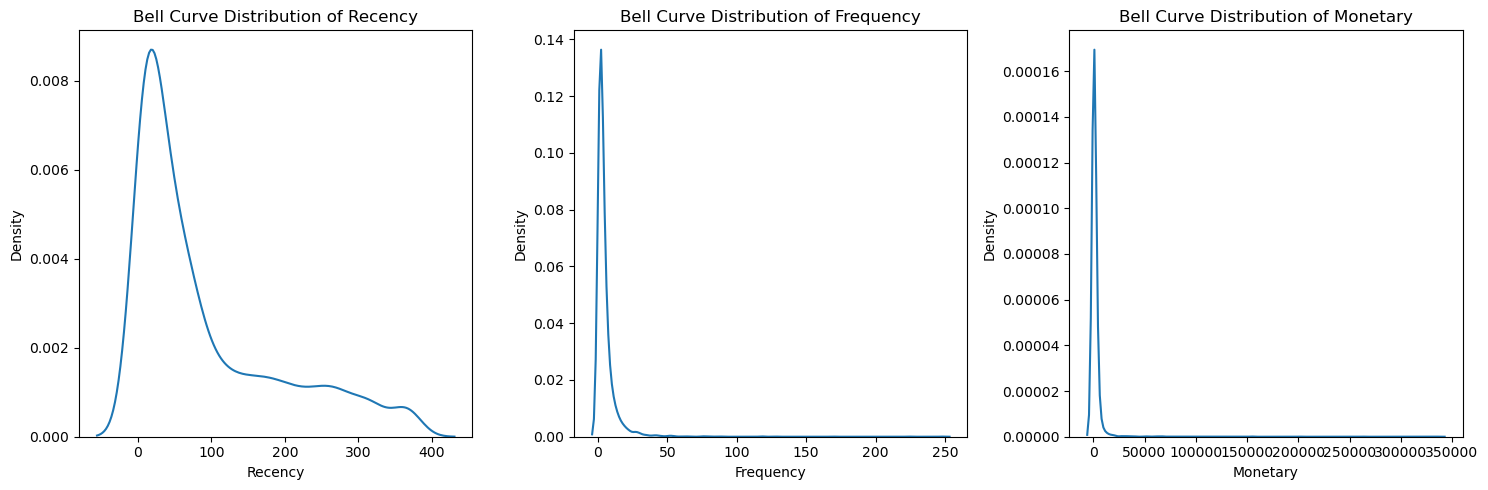

In [342]:
#Check and handle outliers
plt.figure(figsize=(15, 5))
for i, col in enumerate(rfm.columns[1:]):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(rfm[col])
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.title(f"Bell Curve Distribution of {col}")
plt.tight_layout()
plt.show()

In [471]:
#to apply Log transformation, we need to replace 0 value by 1 to prevent Log(0)
rfm['Monetary'] = rfm['Monetary'].apply(lambda x: 1 if x == 0 else x)

#deal with skewed data by performing Log Transformation to bring the data into normal or near-normal distribution
#Reducing the impact of outliers
rfm['Recency_Log'] = rfm['Recency'].apply(lambda row: np.log(row)).round(3)
rfm['Frequency_Log'] = rfm['Frequency'].apply(lambda row: np.log(row)).round(3)
rfm['Monetary_Log'] = rfm['Monetary'].apply(lambda row: np.log(row)).round(3)
rfm

,CustomerID,Recency,Frequency,Monetary,Recency_Log,Frequency_Log,Monetary_Log
0,12346,326,2,154367,6,1,12
1,12347,2,7,4310,1,2,8
2,12348,75,4,1797,4,1,7
3,12349,19,1,1758,3,0,7
4,12350,310,1,334,6,0,6
...,...,...,...,...,...,...,...
4367,18280,278,1,181,6,0,5
4368,18281,181,1,81,5,0,4
4369,18282,8,3,180,2,1,5
4370,18283,4,16,2095,1,3,8


<span style="font-size: 30px;">**----- RFM Segment Analysis by Kmeans -----**</span>
1. Standardize the data.
2. Elbow method.
3. Apply Kmeans.
    3.1. Approach 1: Apply Kmeans for entire dataset (all RFM values) and analyze the insights within each segment.
    3.2. Approach 2: Apply K-means to each of the R,F,M columns to identify clusters for each one and apply Rule-based to assign scores to each cluster based on their mean value.
4. Implement segmentation.
5. Visualize result.

In [472]:
#Standardize the data - Bring data into the same scale for apply KMeans
scale = StandardScaler()
rfm_scale = scale.fit_transform(rfm[['Recency_Log','Frequency_Log','Monetary_Log']])
rfm_scale = pd.DataFrame(rfm_scale, columns = ['Recency_Scale','Frequency_Scale','Monetary_Scale'])
rfm_scale = pd.concat([rfm[['CustomerID','Recency','Frequency','Monetary']], rfm_scale], axis=1)
rfm_scale

,CustomerID,Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale
0,12346,326,2,154367,1,-0,4
1,12347,2,7,4310,-2,1,1
2,12348,75,4,1797,0,0,1
3,12349,19,1,1758,-1,-1,1
4,12350,310,1,334,1,-1,-1
...,...,...,...,...,...,...,...
4367,18280,278,1,181,1,-1,-1
4368,18281,181,1,81,1,-1,-2
4369,18282,8,3,180,-1,0,-1
4370,18283,4,16,2095,-2,2,1


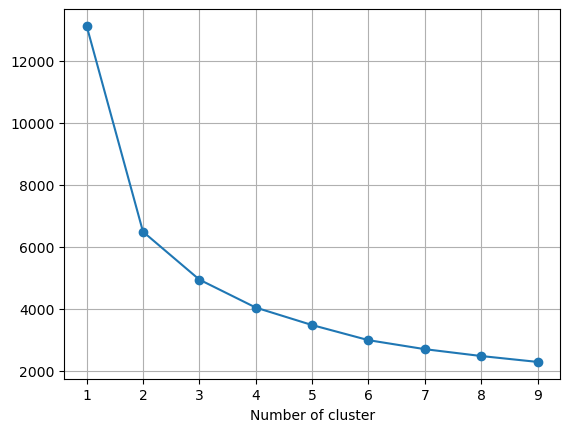

In [473]:
#Get right number of cluster for K-means using Elbow method
def elbow_method(df):
    inertia = {} #sum of squared distances of k
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k,random_state=0, max_iter=1000).fit(df)
        inertia[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(inertia.keys()), list(inertia.values()), marker='o')
    plt.xlabel("Number of cluster")
    plt.grid()
    plt.show()
elbow_method(rfm_scale.iloc[:,4:7])

<span style="font-size: 25px;">**Approach 1:** Apply Kmeans for entire dataset (all RFM values) and analyze the insights within each segment.</span>

In [474]:
#Seperate customer into 4 segment base one RFM
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(rfm_scale[['Recency_Scale','Frequency_Scale','Monetary_Scale']])
rfm_scale['Overall_Cluster'] = kmeans.predict(rfm_scale[['Recency_Scale','Frequency_Scale','Monetary_Scale']])
rfm_scale.head()

,CustomerID,Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale,Overall_Cluster
0,12346,326,2,154367,1,-0,4,0
1,12347,2,7,4310,-2,1,1,2
2,12348,75,4,1797,0,0,1,0
3,12349,19,1,1758,-1,-1,1,3
4,12350,310,1,334,1,-1,-1,1


<span style="font-size: 15px;">**Based on the distribution of each segment, we can derive insights for each one as below:**</span> 

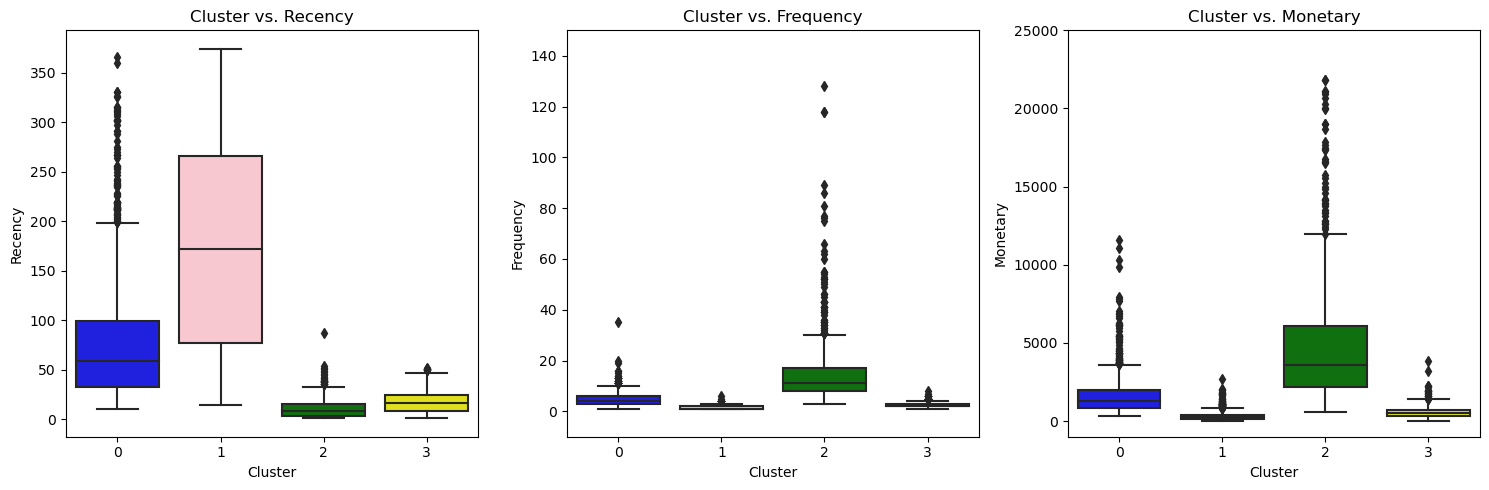

In [449]:
#Visualization Result
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['blue', 'pink', 'green','yellow',]

# Boxplot of Cluster vs. Recency
sns.boxplot(x='Overall_Cluster', y='Recency', data=rfm_scale, ax=axes[0], palette=colors)
axes[0].set_title('Cluster vs. Recency')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Recency')

# Boxplot of Cluster vs. Frequency
sns.boxplot(x='Overall_Cluster', y='Frequency', data=rfm_scale, ax=axes[1], palette=colors)
axes[1].set_title('Cluster vs. Frequency')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Frequency')
axes[1].set_ylim(-10, 150)

# Boxplot of Cluster vs. Monetary
sns.boxplot(x='Overall_Cluster', y='Monetary', data=rfm_scale, ax=axes[2], palette=colors)
axes[2].set_title('Cluster vs. Monetary')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Monetary')
axes[2].set_ylim(-1000, 25000)

plt.tight_layout()
plt.show()

 Cluster 0: Named "Need Attention": who purchased often and spent big amounts, but haven't purchased recently and are about to lost.
 
 Cluster 1: Named "Lost Customer": customer who havent visites the shop for a long time and dont spend much money in this shop.
 
 Cluster 2: Named "Best Customer": who bought most recently, most often, and are heavy spenders.
 
 Cluster 3: Named "New Customer": who Bought more recently, but not often and haven’t spent much.

In [570]:
df_segment = rfm_scale.groupby('Overall_Cluster').agg({
                                    'CustomerID': 'nunique',
                                    'Recency': 'mean',
                                    'Frequency':'mean',
                                    'Monetary':'mean'
                                })
df_segment.columns = ['Number of Customer','Avg Recency','Avg Frequency','Avg Monetary']
df_segment.reset_index(inplace=True)

segment_map = {
                0: 'Need Attention',
                1: 'Lost',
                2: 'Best Customer',
                3: 'New Customer'
                }
df_segment['Segment'] = df_segment['Overall_Cluster'].map(segment_map)
df_segment

,Overall_Cluster,Number of Customer,Avg Recency,Avg Frequency,Avg Monetary,Segment
0,0,1221,79,5,1852,Need Attention
1,1,1587,179,1,327,Lost
2,2,778,10,16,8089,Best Customer
3,3,786,17,2,570,New Customer


<span style="font-size: 25px;">**Approach 2:** Apply K-means to each of the R,F,M columns to identify clusters for each one and apply Rule-based to assign scores to each cluster based on their mean value.</span>

In [475]:
kmeans = KMeans(n_clusters=4, random_state=0)

kmeans.fit(rfm_scale[['Recency_Scale']])
rfm_scale['Recency_Cluster'] = kmeans.predict(rfm_scale[['Recency_Scale']])

kmeans.fit(rfm_scale[['Frequency_Scale']])
rfm_scale['Frequency_Cluster'] = kmeans.predict(rfm_scale[['Frequency_Scale']])

kmeans.fit(rfm_scale[['Monetary_Scale']])
rfm_scale['Monetary_Cluster'] = kmeans.predict(rfm_scale[['Monetary_Scale']])

rfm_scale

,CustomerID,Recency,Frequency,Monetary,Recency_Scale,Frequency_Scale,Monetary_Scale,Overall_Cluster,Recency_Cluster,Frequency_Cluster,Monetary_Cluster
0,12346,326,2,154367,1,-0,4,0,2,0,1
1,12347,2,7,4310,-2,1,1,2,1,3,1
2,12348,75,4,1797,0,0,1,0,0,3,3
3,12349,19,1,1758,-1,-1,1,3,3,2,3
4,12350,310,1,334,1,-1,-1,1,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...
4367,18280,278,1,181,1,-1,-1,1,2,2,2
4368,18281,181,1,81,1,-1,-2,1,2,2,2
4369,18282,8,3,180,-1,0,-1,3,3,0,2
4370,18283,4,16,2095,-2,2,1,2,1,1,3


In [385]:
#A smaller Recency value is better whereas higher Frequency and Monetary values are better.
#A higher R-score is assigned to cluster with smaller mean values
#while a lower F-score and M - score is assigned to cluster with smaller mean values 
#within a scale from 1 to 4."

df_recency_rank = rfm_scale.groupby('Recency_Cluster')['Recency'].mean().reset_index()
df_recency_rank.columns=['Recency_Cluster','Mean_Value']
df_recency_rank['Rank'] = df_recency_rank['Mean_Value'].rank(ascending=False, method='dense')

df_frequency_rank = rfm_scale.groupby('Frequency_Cluster')['Frequency'].mean().reset_index()
df_frequency_rank.columns=['Frequency_Cluster','Mean_Value']
df_frequency_rank['Rank'] = df_frequency_rank['Mean_Value'].rank(ascending=True, method='dense')

df_monetary_rank = rfm_scale.groupby('Monetary_Cluster')['Monetary'].mean().reset_index()
df_monetary_rank.columns=['Monetary_Cluster','Mean_Value']
df_monetary_rank['Rank'] = df_monetary_rank['Mean_Value'].rank(ascending=True, method='dense')

df_monetary_rank


,Monetary_Cluster,Mean_Value,Rank
0,0,497,2
1,1,12292,4
2,2,150,1
3,3,1697,3


In [480]:
#Merge df_recency_rank
rfm_final = pd.merge(rfm_scale, df_recency_rank[['Recency_Cluster', 'Rank']], on='Recency_Cluster').drop(columns='Recency_Cluster')
rfm_final.rename(columns = {'Rank': 'R-Score'}, inplace=True)

#Merge df_frequency_rank
rfm_final = pd.merge(rfm_final, df_frequency_rank[['Frequency_Cluster', 'Rank']], on='Frequency_Cluster').drop(columns='Frequency_Cluster')
rfm_final.rename(columns = {'Rank': 'F-Score'}, inplace=True)

#Merge df_monetary_rank
rfm_final = pd.merge(rfm_final, df_monetary_rank[['Monetary_Cluster', 'Rank']], on='Monetary_Cluster').drop(columns='Monetary_Cluster')
rfm_final.rename(columns = {'Rank': 'M-Score'}, inplace=True)

rfm_final['RFM'] = rfm_final['R-Score'].map(int).map(str) + rfm_final['F-Score'].map(int).map(str) + rfm_final['M-Score'].map(int).map(str)
rfm_final.drop(columns=['Recency_Scale','Frequency_Scale','Monetary_Scale'],inplace=True)
rfm_final.head()

,CustomerID,Recency,Frequency,Monetary,Overall_Cluster,R-Score,F-Score,M-Score,RFM
0,12346,326,2,154367,0,1,2,4,124
1,12590,190,3,9867,0,1,2,4,124
2,16000,3,3,12394,2,4,2,4,424
3,16446,1,3,336942,2,4,2,4,424
4,12435,80,2,7830,0,2,2,4,224


In [613]:
subset_map = {
            '444':'Champions', #Bought recently, buy often and spend the most.
            '111':'Lost', #Lowest recency, frequency and monetary values.
            '[2-4][3-4][3-4]':'Potential Loyalists', #Spend good money. Above average recency, frequency. Core customers.
            '[1-3][1-2][3-4]': 'Big Spender', #Spend the most.
            '[3-4][1-3][1-2]':'New Customers', #Bought more recently, but not often and haven’t spent much.
            '[1-2][1-3][1-4]':'At Risk', #Spent above avg monetary values, purchased often but long time ago.
            }
def sub_segment_rfm(rfm):
    for pattern, segment in subset_map.items():
        if re.search(pattern, rfm):
            return segment
    return 'Others'

rfm_final['Sub-Segment'] = rfm_final['RFM'].apply(sub_segment_rfm)

segment_map = {
                0: 'Need Attention',
                1: 'Lost',
                2: 'Best Customer',
                3: 'New Customer'
                }
rfm_final['Segment'] = rfm_final['Overall_Cluster'].map(segment_map)
rfm_final

,CustomerID,Recency,Frequency,Monetary,Overall_Cluster,R-Score,F-Score,M-Score,RFM,Sub-Segment,Segment
0,12346,326,2,154367,0,1,2,4,124,Big Spender,Need Attention
1,12590,190,3,9867,0,1,2,4,124,Big Spender,Need Attention
2,16000,3,3,12394,2,4,2,4,424,Others,Best Customer
3,16446,1,3,336942,2,4,2,4,424,Others,Best Customer
4,12435,80,2,7830,0,2,2,4,224,Big Spender,Need Attention
...,...,...,...,...,...,...,...,...,...,...,...
4367,16462,64,4,170,1,2,3,1,231,At Risk,Lost
4368,17572,71,4,227,1,2,3,1,231,At Risk,Lost
4369,17816,37,4,37,1,2,3,1,231,At Risk,Lost
4370,14287,8,4,202,3,3,3,1,331,New Customers,New Customer


In [615]:
df_segment = rfm_final.groupby(['Segment','Sub-Segment']).agg({
                                    'CustomerID': 'nunique',
                                    'Recency': 'mean',
                                    'Frequency':'mean',
                                    'Monetary':'mean'
                                })
df_segment.columns = ['Number of Customer','Avg Recency','Avg Frequency','Avg Monetary']
df_segment.reset_index(inplace=True)
df_segment

,Segment,Sub-Segment,Number of Customer,Avg Recency,Avg Frequency,Avg Monetary
0,Best Customer,Big Spender,1,10,3,6977
1,Best Customer,Champions,156,3,32,17365
2,Best Customer,New Customers,2,2,7,647
3,Best Customer,Others,2,2,3,174668
4,Best Customer,Potential Loyalists,617,12,12,5230
5,Lost,At Risk,1100,154,2,350
6,Lost,Big Spender,63,179,1,1205
7,Lost,Lost,408,254,1,140
8,Lost,New Customers,16,25,1,107
9,Need Attention,At Risk,379,116,4,1339


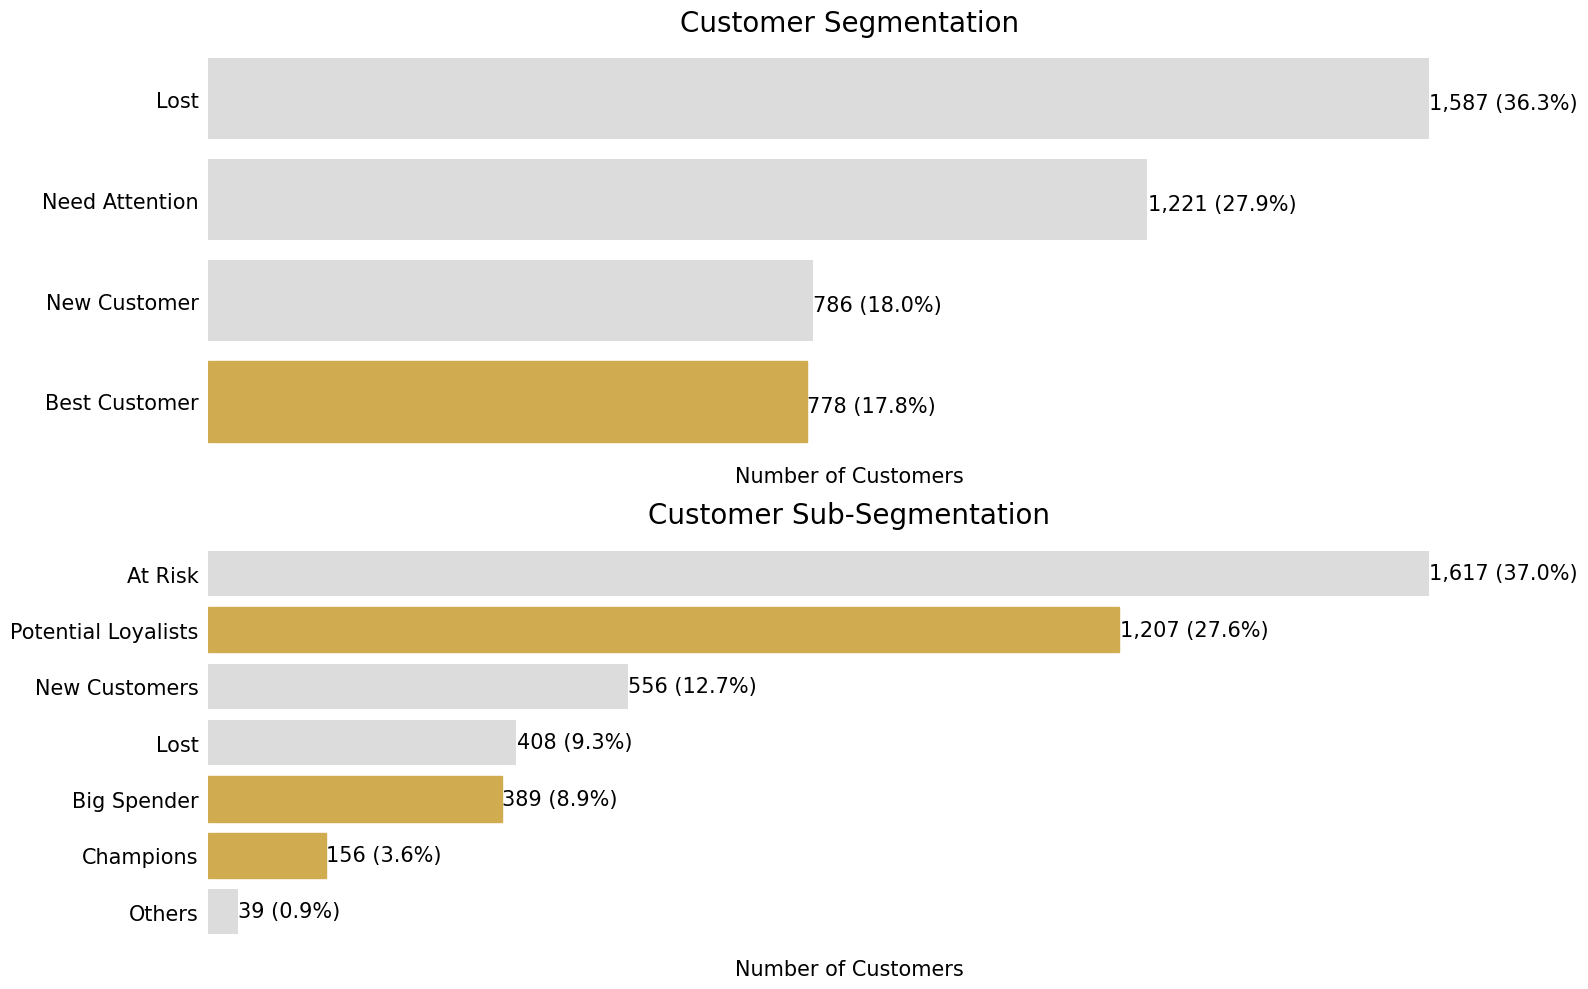

In [664]:
# Data for the horizontal bar charts
segments_counts = rfm_final['Segment'].value_counts()
sub_segments_counts = rfm_final['Sub-Segment'].value_counts()

# Create the subplots
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Subplot 1: Customer Segmentation
ax1 = axes[0].barh(segments_counts.index, segments_counts, color='#DCDCDC')
axes[0].invert_yaxis() #Invert the y-axis to display the largest segment at the top
axes[0].set_frame_on(False) #Remove frame
axes[0].tick_params(left=False, bottom=False, labelbottom=False)
axes[0].set_yticklabels(segments_counts.index, fontsize=15)
axes[0].set_xlabel('Number of Customers', fontsize=15)
axes[0].set_title('Customer Segmentation', fontsize=20)

for i, segment in enumerate(ax1.patches):
    x = segment.get_width() + 0.5
    y = segment.get_y() + 0.5
    axes[0].text(x, y, '{:,} ({:.1f}%)'.format(int(x), (x * 100 / segments_counts.sum())), fontsize=15)
    if segments_counts.index[i] == 'Best Customer':
        segment.set_color('#D1AB4F')
# Subplot 2: Customer Sub-Segmentation
ax2 = axes[1].barh(sub_segments_counts.index, sub_segments_counts, color='#DCDCDC')
axes[1].invert_yaxis()
axes[1].set_frame_on(False)
axes[1].tick_params(left=False, bottom=False, labelbottom=False)
axes[1].set_yticklabels(sub_segments_counts.index, fontsize=15)
axes[1].set_xlabel('Number of Customers', fontsize=15)
axes[1].set_title('Customer Sub-Segmentation', fontsize=20)

for i, segment in enumerate(ax2.patches):
    x = segment.get_width() + 0.5
    y = segment.get_y() + 0.5
    axes[1].text(x, y, '{:,} ({:.1f}%)'.format(int(x), (x * 100 / sub_segments_counts.sum())), fontsize=15)
    if sub_segments_counts.index[i] in ['Champions', 'Potential Loyalists','Big Spender']:
        segment.set_color('#D1AB4F')

# Adjust the layout
plt.tight_layout()

# Show the subplots
plt.show()


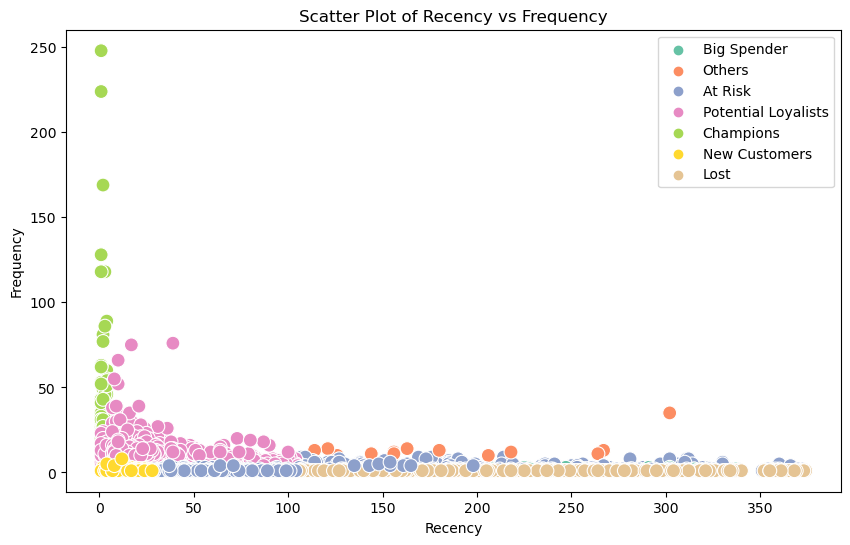

In [618]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=rfm_final['Recency'],
    y=rfm_final['Frequency'],
    hue=rfm_final['Sub-Segment'],
    palette='Set2',  
    s=100,  
)

plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Scatter Plot of Recency vs Frequency')
plt.legend()
plt.show()